<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-11-24 17:41:16--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-11-24 17:41:16 (146 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


The data set contains two empty columns that are unnecessary.  Columns 'Unnamed: 0','Unnamed: 0.1' and removed from the data frame via the step below.

In [3]:
df = pd.read_csv('loan_train.csv')
df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis = 1)
df.head()




,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 8)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



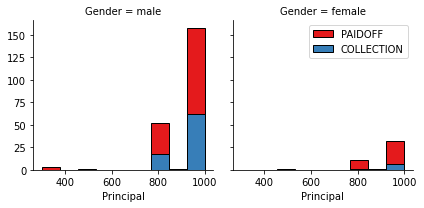

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

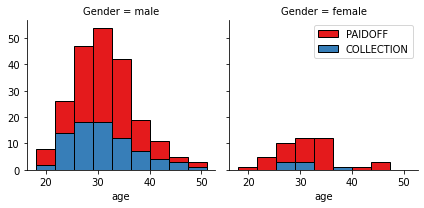

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


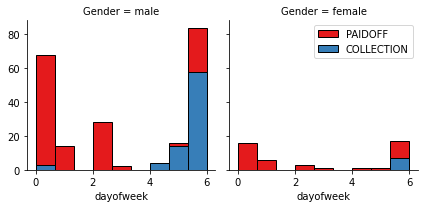

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


# #Let's convert male to 0 and female to 1 and rename Bechalor to college:
# Note that this is converting what looks like a bad value into a correct one.


The data appeared to have two unneccisary fields which were removed and also an invalid value in the Education column.  The value 'bechalor' was replaced with 'college' as I interprted the meaning of 'bechalor' to be a misspelling of 'bachelor' which insinutates a bachelors degree which corresponds to the value 'college'

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=[1,0], value=['PAIDOFF','COLLECTION'],inplace=True)
#Clean data replace bad value with appropriate value.
df.replace('Bechalor', 'college', inplace=True)
df['education'].replace(to_replace=['High School or Below','Master or Above','college'], value=[0,1,1],inplace=True)
df.head()

df_dt = df




## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education  loan_status
0          PAIDOFF        0.741722
           COLLECTION     0.258278
1          PAIDOFF        0.758974
           COLLECTION     0.241026
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education','weekend']].head()

df_cleaned = df[['Principal','terms','age','Gender','education','weekend']]

df_cleaned.head()



,Principal,terms,age,Gender,education,weekend
0,1000,30,45,0,0,0
1,1000,30,33,1,1,0
2,1000,15,27,0,1,0
3,1000,30,28,1,1,1
4,1000,30,29,0,1,1


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

#Feature = df[['Principal','terms','age','Gender','weekend', 'education']]

Feature = df_cleaned

Feature

,Principal,terms,age,Gender,education,weekend
0,1000,30,45,0,0,0
1,1000,30,33,1,1,0
2,1000,15,27,0,1,0
3,1000,30,28,1,1,1
4,1000,30,29,0,1,1
...,...,...,...,...,...,...
341,800,15,32,0,0,1
342,1000,30,25,0,0,1
343,800,15,39,0,1,0
344,1000,30,28,0,1,0


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X_dt = X
X[0:20]

,Principal,terms,age,Gender,education,weekend
0,1000,30,45,0,0,0
1,1000,30,33,1,1,0
2,1000,15,27,0,1,0
3,1000,30,28,1,1,1
4,1000,30,29,0,1,1
5,1000,30,36,0,1,1
6,1000,30,28,0,1,1
7,800,15,26,0,1,1
8,300,7,29,0,1,1
9,1000,15,39,0,0,1


What are our lables?


In [18]:
y = df['loan_status']
y_dt = y
y[0:20]


0     PAIDOFF
1     PAIDOFF
2     PAIDOFF
3     PAIDOFF
4     PAIDOFF
5     PAIDOFF
6     PAIDOFF
7     PAIDOFF
8     PAIDOFF
9     PAIDOFF
10    PAIDOFF
11    PAIDOFF
12    PAIDOFF
13    PAIDOFF
14    PAIDOFF
15    PAIDOFF
16    PAIDOFF
17    PAIDOFF
18    PAIDOFF
19    PAIDOFF
Name: loan_status, dtype: object

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [151]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:8]

array([[ 0.515784583 ,  0.9207176908,  2.3315255462, -0.4205600413,
        -1.2057780514, -1.1363937383],
       [ 0.515784583 ,  0.9207176908,  0.3417014829,  2.3777817717,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 , -0.9591111115, -0.6532105487, -0.4205600413,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.4873918768,  2.3777817717,
         0.8293400256,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.3215732048, -0.4205600413,
         0.8293400256,  0.8799766897],
       [ 0.515784583 ,  0.9207176908,  0.8391574987, -0.4205600413,
         0.8293400256,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.4873918768, -0.4205600413,
         0.8293400256,  0.8799766897],
       [-1.3145894244, -0.9591111115, -0.8190292207, -0.4205600413,
         0.8293400256,  0.8799766897]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


# Create test and train datasets

In [152]:
## Setup train and test data sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

X_train

Train set: (276, 6) (276,)
Test set: (70, 6) (70,)


array([[ 0.515784583 , -0.9591111115,  0.6733388268, -0.4205600413,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.8190292207, -0.4205600413,
         0.8293400256, -1.1363937383],
       [ 0.515784583 ,  0.9207176908,  0.010064139 , -0.4205600413,
        -1.2057780514,  0.8799766897],
       ...,
       [ 0.515784583 , -0.9591111115, -0.6532105487, -0.4205600413,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.8190292207, -0.4205600413,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.1557545329, -0.4205600413,
         0.8293400256, -1.1363937383]])

# Import libraries, fit the training data, and report accuracy

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k = 5
#Train Model and Predict  
loan_knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

yhat_knn = loan_knn.predict(X_test)
#yhat_knn[0:5]
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loan_knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_knn))


Train set Accuracy:  0.8007246376811594
Test set Accuracy:  0.7714285714285715


# Determine most accurate K value within a range of 1 to 10.

In [157]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    loan_knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=loan_knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])
    

mean_acc


array([0.7285714286, 0.6571428571, 0.7714285714, 0.7285714286,
       0.7714285714, 0.6857142857, 0.7714285714, 0.6857142857,
       0.7571428571, 0.7142857143, 0.7142857143, 0.6857142857,
       0.6714285714, 0.6714285714, 0.6714285714, 0.7         ,
       0.7142857143, 0.7         , 0.7         ])

In [158]:
print( "The best accuracy was with", mean_acc.max(), "with K=", mean_acc.argmax()+1) 

The best accuracy was with 0.7714285714285715 with K= 3


# Visualization of K value accurracy for values from 1 to 10.

<function matplotlib.pyplot.show(close=None, block=None)>

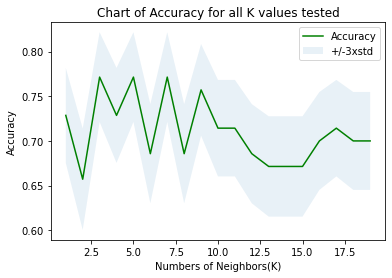

In [159]:
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha = 0.10)
plt.title('Chart of Accuracy for all K values tested')
plt.legend(('Accuracy', '+/-3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Numbers of Neighbors(K)')

plt.tight_layout

plt.show

# Decision Tree


# Import packages and libraries. Install pydotplus from conda.


In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import f1_score


In [27]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

!conda update -n base -c defaults conda update -n base -c defaults condacond

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.8-main

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py38h578d9bd_1         145 KB  conda-forge
    pydotplus-2.0.2            |             py_1          22 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         171 KB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-py_1
  python_abi         conda-forge/linux-64::python_abi-3.8-2_cp38

The following packages will be UPDATED:

  certifi            pkgs/main::certifi-2021.10.8-py38h06a~ --> conda-forge::certifi-2021.10.8-py38h578d9bd_1



pydotplus-2.0.2

# Create decision tree object and fit the training data.

Below we are using the non normalized.  
This will keep our choices binanry in nature making the decision tree more clear.

In [165]:
loan_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)

loan_tree.fit(X_train, y_train)

print(loan_tree)

predTree = loan_tree.predict(X_test)

DecisionTreeClassifier(criterion='entropy', max_depth=6)


In [168]:
max_depth_range = list(range(1, 10))
# List to store the accuracy for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)
    
print(accuracy)

[0.7857142857142857, 0.7857142857142857, 0.6142857142857143, 0.6142857142857143, 0.6285714285714286, 0.6571428571428571, 0.7285714285714285, 0.7142857142857143, 0.7142857142857143]


# Decision Tree Accuracy:

In [169]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.6571428571428571


## Create Visualization of Decision Tree

In [184]:
Ks = 6
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  

    loan_Tree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat_lt=loan_Tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_lt)

    
    std_acc[n-1]=np.std(yhat_lt==y_test)/np.sqrt(yhat_lt.shape[0])

mean_acc

X

array([[ 0.515784583 ,  0.9207176908,  2.3315255462, -0.4205600413,
        -1.2057780514, -1.1363937383],
       [ 0.515784583 ,  0.9207176908,  0.3417014829,  2.3777817717,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 , -0.9591111115, -0.6532105487, -0.4205600413,
        -1.2057780514,  0.8799766897],
       ...,
       [-1.3145894244, -0.9591111115,  1.3366135146, -0.4205600413,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.4873918768, -0.4205600413,
        -1.2057780514,  0.8799766897],
       [ 0.515784583 ,  0.9207176908, -0.8190292207, -0.4205600413,
        -1.2057780514,  0.8799766897]])

# Support Vector Machine


In [171]:
#Reload the source file to start with a fresh set of data
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
    
#Create a new data frame for the SVM from the loaded csv file.
df_svm = pd.read_csv('loan_train.csv')

#Clean up the date formats and create a dayofweek variable based on the effective date of the loan
df_svm['due_date'] = pd.to_datetime(df_svm['due_date'])
df_svm['effective_date'] = pd.to_datetime(df_svm['effective_date'])
df_svm['dayofweek'] = df_svm['effective_date'].dt.dayofweek
df_svm['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df_svm['loan_status'].replace(to_replace=[1,0], value=['PAIDOFF','COLLECTION'],inplace=True)
df_svm.replace('Bechalor', 'college', inplace=True)
df_svm['education'].replace(to_replace=['High School or Below','Master or Above','college'], value=[0,1,1],inplace=True)
df_svm['weekend'] = df_svm['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

df_svm.head()


--2021-11-24 20:18:05--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-11-24 20:18:05 (149 MB/s) - ‘loan_train.csv’ saved [23101/23101]



,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,0,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,1,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,1,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,1,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,1,0,4,1


In [188]:
Feature_svm = df_svm[['Principal','terms','age','Gender','weekend']]
Feature_svm = pd.concat([Feature,pd.get_dummies(df_svm['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature_svm.head()

Feature_svm = df[['Principal','terms','age','Gender','weekend', 'education']]

X_svm = Feature_svm
y_svm = df_svm['loan_status']


In [192]:
#Reset the test and training data based on the change to loan_Status values
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split( X_svm, y_svm, stratify=y, test_size=0.2, random_state=4)

from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn import svm

loan_svm = svm.SVC(kernel='linear')
loan_svm.fit(X_train_svm, y_train_svm) 

yhat_svm = clf.predict(X_test_svm)
yhat_svm [0:20]

X_train_svm



,Principal,terms,age,Gender,weekend,education
240,800,15,36,0,0,1
16,1000,30,32,0,1,0
13,800,15,26,0,1,1
220,1000,15,37,1,0,1
130,1000,30,34,0,0,1
...,...,...,...,...,...,...
272,1000,15,24,0,1,1
231,800,30,40,1,0,1
41,800,15,50,0,1,0
95,1000,30,40,0,1,1


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        17
     PAIDOFF       0.76      1.00      0.86        53

    accuracy                           0.76        70
   macro avg       0.38      0.50      0.43        70
weighted avg       0.57      0.76      0.65        70

Confusion matrix, without normalization
[[0 0]
 [0 0]]


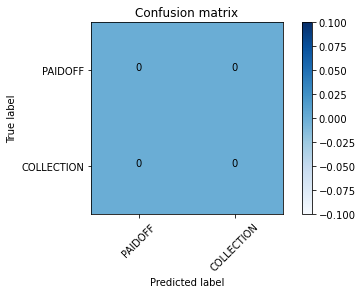

In [194]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix for Loan Dataset',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix_svm = confusion_matrix(y_test_svm, yhat_svm, labels=['PAID','COLLECTION'])
np.set_printoptions(precision=10)

print (classification_report(y_test_svm, yhat_svm))

# Plot non-normalized confusion matrix
plt.figure()

plot_confusion_matrix(cnf_matrix_svm, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')



# Logistic Regression


In [195]:
#Reuse the svm data frames for this calculation instead of reloading and pre processing the same data
df_lr = df_svm
X_lr = X_svm
y_lr = y_svm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size = 0.25, random_state = 4)

loan_lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_lr,y_train_lr)
yhat_lr = loan_lr.predict(X_test_lr)
yhat_prob_lr = loan_lr.predict_proba(X_test_lr)
yhat_prob_lr[0:20]


array([[0.300726526 , 0.699273474 ],
       [0.2404870134, 0.7595129866],
       [0.1722684688, 0.8277315312],
       [0.3022950578, 0.6977049422],
       [0.2290260803, 0.7709739197],
       [0.1948710535, 0.8051289465],
       [0.255346768 , 0.744653232 ],
       [0.227713643 , 0.772286357 ],
       [0.3022950578, 0.6977049422],
       [0.2795768244, 0.7204231756],
       [0.2866157094, 0.7133842906],
       [0.29956038  , 0.70043962  ],
       [0.2947204511, 0.7052795489],
       [0.2800791663, 0.7199208337],
       [0.1318642742, 0.8681357258],
       [0.1579111589, 0.8420888411],
       [0.3677457359, 0.6322542641],
       [0.1769071911, 0.8230928089],
       [0.3156345541, 0.6843654459],
       [0.2105696931, 0.7894303069]])

Confusion matrix, without normalization
[[64  0]
 [23  0]]


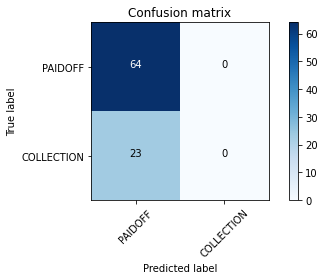

In [196]:
cnf_matrix_lr = confusion_matrix(y_test_lr, yhat_lr, labels=['PAIDOFF','COLLECTION'])

np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix_lr, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Model Evaluation using Test set


In [197]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [198]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-11-24 20:35:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-11-24 20:35:15 (59.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [199]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
test_df.shape


(54, 10)

### Preprocess dataframe as we did at the beginning of the excercise.  Including conversion of 'Bechalor' to 'college' as 'Bechelor' appears to be a misspelling of 'Bachelor' which is synonomous with college educated.  In the real world this would be verified with the owner of the source data.

In [200]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df_svm['effective_date'])
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace=[1,0], value=['PAIDOFF','COLLECTION'],inplace=True)
test_df.replace('Bechalor', 'college', inplace=True)
test_df['education'].replace(to_replace=['High School or Below','Master or Above','college'], value=[0,1,1],inplace=True)
test_df['weekend'] = df_svm['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,1,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,1,0,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,0,1,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,1,0,4,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,1,0,4,1


In [128]:
#create feature from data frame created from csv.
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
test_feature.head()

#create new feature value for testing
test_feature = test_df[['Principal','terms','age','Gender','weekend', 'education']]
test_feature = preprocessing.StandardScaler().fit(test_feature).transform(test_feature)

#create new X and Y values
test_X = test_feature
test_y = test_df['loan_status']

test_X


array([[ 0.49,  0.93,  3.06,  1.98, -4.12,  0.8 ],
       [-3.56, -1.7 ,  0.53, -0.51, -4.12,  0.8 ],
       [ 0.49,  0.93,  1.88,  1.98, -4.12, -1.25],
       [ 0.49,  0.93, -0.98, -0.51,  0.24,  0.8 ],
       [-0.67, -0.79, -0.48, -0.51,  0.24,  0.8 ],
       [-1.24, -0.79,  0.2 , -0.51,  0.24, -1.25],
       [ 0.49, -0.79, -1.32, -0.51,  0.24,  0.8 ],
       [ 0.49,  0.93,  0.03, -0.51,  0.24,  0.8 ],
       [-0.67, -0.79, -0.81,  1.98,  0.24,  0.8 ],
       [ 0.49, -0.79,  0.87, -0.51,  0.24,  0.8 ],
       [-0.67, -0.79, -1.32, -0.51,  0.24, -1.25],
       [-3.56, -1.7 ,  0.53, -0.51,  0.24,  0.8 ],
       [ 0.49,  0.93, -0.14, -0.51,  0.24,  0.8 ],
       [ 0.49,  0.93,  0.87,  1.98,  0.24,  0.8 ],
       [ 0.49,  0.93,  0.87,  1.98,  0.24, -1.25],
       [ 0.49,  0.93,  0.2 , -0.51,  0.24,  0.8 ],
       [-0.67, -0.79,  1.88, -0.51,  0.24,  0.8 ],
       [ 0.49, -1.7 ,  0.03,  1.98,  0.24,  0.8 ],
       [ 0.49, -0.79, -0.98, -0.51,  0.24, -1.25],
       [ 0.49, -1.7 , -0.48, -0

In [201]:
jaccard_similarity_score_knn = jaccard_score(test_y, loan_knn.predict(test_feature), average='weighted')
jaccard_similarity_score_dt = jaccard_score(test_y, loan_tree.predict(test_feature), average='weighted')
jaccard_similarity_score_svm = jaccard_score(test_y, loan_svm.predict(test_feature), average='weighted')
jaccard_similarity_score_lr = jaccard_score(test_y, loan_lr.predict(test_feature), average='weighted')
print('jaccard_similarity_score_knn',jaccard_similarity_score_knn )
print('jaccard_similarity_score_dt', jaccard_similarity_score_dt)
print('jaccard_similarity_score_svm', jaccard_similarity_score_svm)
print('jaccard_similarity_score_lr', jaccard_similarity_score_lr)

jaccard_similarity_score_knn 0.48407060086514475
jaccard_similarity_score_dt 0.4745862884160757
jaccard_similarity_score_svm 0.5486968449931412
jaccard_similarity_score_lr 0.2746195808211312


In [202]:
f1score_knn = f1_score(test_y, loan_knn.predict(test_feature), average = 'weighted')
f1score_dt = f1_score(test_y, loan_tree.predict(test_feature), average = 'weighted')
f1score_svm = f1_score(test_y, loan_svm.predict(test_feature), average = 'weighted')
f1score_lr = f1_score(test_y, loan_lr.predict(test_feature) ,average = 'weighted')
print('f1score_knn', f1score_knn)
print('f1score_dt', f1score_dt)
print('f1score_svm', f1score_svm)
print('f1score_lr', f1score_lr)


f1score_knn 0.6199013272184005
f1score_dt 0.6313546423135463
f1score_svm 0.6304176516942475
f1score_lr 0.4308493742456006


In [203]:
log_loss_knn = log_loss(test_y, loan_lr.predict_proba(test_feature))
log_loss_dt = log_loss(test_y, loan_knn.predict_proba(test_feature))
log_loss_svm = log_loss(test_y, loan_knn.predict_proba(test_feature))
log_loss_lr = log_loss(test_y, loan_knn.predict_proba(test_feature))
print('log_loss_knn', log_loss_knn)
print('log_loss_dt', log_loss_dt)
print('log_loss_svm', log_loss_svm)
print('log_loss_lr', log_loss_lr)


log_loss_knn 0.6822210868441441
log_loss_dt 0.5671779833050868
log_loss_svm 0.5671779833050868
log_loss_lr 0.5671779833050868


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


Updated report with values derived from test data.

| Algorithm          | Jaccard | F1-score     | LogLoss |
| ------------------ | ------- | --------     | ------- |
| KNN                | .48815  | .6199        | NA      |
| Decision Tree      | .47458  | .6313        | NA      |
| SVM                | .54869  | .6304        | NA      |
| LogisticRegression | .27456  | .4308        | .056717 |       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
